# Housekeeping

In [22]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

## Preparing the data needed

In [23]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('Date').drop(columns='rf')
factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')

conn.close()

### making sure all the data is in the same format
factor_ret_d.index = pd.to_datetime(factor_ret_d.index)
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)

### Since the BAB factor start in 1983, we will only consider the data from 1983 onwards
factor_ret_d = factor_ret_d['1983':]
factor_ret_m = factor_ret_m['1983':]

### Looking if we have any NaN
print(factor_ret_d.isna().sum().sum(), factor_ret_m.isna().sum().sum())

0 0


To compute the monthly volatilities and variances for each factor, we utilize daily data. Since the UMD and BAB factors are constructed by us, we have already applied the respective monthly weights to the daily data. Specifically, at the beginning of each month, we allocate capital to stocks according to that month's predetermined weights, maintaining these positions without rebalancing until the subsequent month.

For the HML, SMB, EW, and VW factors, we assume, for simplicity, that their weights do not exhibit substantial daily variation. Consequently, we use their daily rebalanced returns as a proxy for estimating monthly volatility and variance. This approach ensures consistency across factors while reducing the complexity associated with daily weight adjustments.

In [24]:
### Getting the daily volatilites we are missing using the daily returns
volatility = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
variance = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        volatility.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].std() * np.sqrt(252)
        variance.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].var() * 252

### Looking if we have any NaN
print(volatility.isna().sum().sum(), variance.isna().sum().sum())

0 0


To ensure that the volatility of both the original factor and the volatility-managed factor remains the same, we will select an appropriate value for $c$. This scaling parameter $c$ is chosen such that the standard deviation of the volatility-managed factor matches that of the original factor.

Mathematically, we define $c$ such that:

$$Std \left ( \frac{c}{\sigma^2_{k,t}} r_{k,t+1} \right ) = Std \left ( r_{k,t+1} \right ) \quad \text{ or } \quad Std \left ( \frac{c}{\sigma^2_{m,t}} r_{k,t+1} \right ) = Std \left ( r_{k,t+1} \right )$$

We will compute two values of $c$ for each factor, one for when we scale with $\sigma_k^2$ and another for when we scale with $\sigma_m^2$.

In [25]:
### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / variance[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / variance['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

print(c)

          VW     EW    SMB    HML    UMD    BAB
c_fac 0.0184 0.0139 0.0170 0.0197 0.0204 0.0191
c_mkt 0.0184 0.0196 0.0217 0.0231 0.0172 0.0176


The volatility-timed factors are then defined as:

$$r_{k,t+1}^{\sigma_k}=\frac{c}{\sigma^2_{k,t}} r_{k,t+1} \quad \text{ or } \quad r_{k,t+1}^{\sigma_m}=\frac{c}{\sigma^2_{m,t}} r_{k,t+1}$$

In [26]:
### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / variance[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / variance['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

Now, we construct new dataframes that incorporate both the volatility-timed factor and the original factor. We then apply mean-variance optimization, utilizing the past five years of data to determine the optimal weights for both returns and a risk-free asset.

Since we are working with excess returns, the excess return on the risk-free asset is $0\%$. In accordance with the referenced paper, we set $\gamma = 5$, although the choice of $\gamma$ does not impact the Sharpe ratios significantly. 

To ensure more realistic results, we impose a no-short-selling constraint.


In [27]:
### Defining the starting window size
window = 120

### Creating a place to store the returns
r_sigma_k_ptf, r_sigma_m_ptf = pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,], pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,]
r_sigma_k_ptf_is, r_sigma_m_ptf_is = pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,], pd.DataFrame(columns=r.columns, index=r.index).iloc[window:,]

### Creating a place to store the out-of-sample weights
r_sigma_k_ptf_w, r_sigma_m_ptf_w = r_sigma_k_ptf.copy(), r_sigma_m_ptf.copy()

### Running the loop
for factor in r.columns:

    ## Starting with creating a dataframe we will use and getting the dates
    data = pd.concat([r[factor], r_sigma_k[factor], r_sigma_m[factor]], axis=1).dropna()
    dates = data.index

    for i in range(window, len(data)):
        # Getting the data we need for the expanding window
        data_window = data.iloc[:i,]

        # Getting the different weights
        w_k = ptf_weights(data_window.iloc[:,[0,1]], negative=False, type='MVP', gamma = 5, wanted_weight='None')
        w_m = ptf_weights(data_window.iloc[:,[0,2]], negative=False, type='MVP', gamma = 5, wanted_weight='None')

        # Getting the returns
        r_sigma_k_ptf.loc[dates[i], factor] = (w_k * data.iloc[i,[0,1]].values).sum()
        r_sigma_m_ptf.loc[dates[i], factor] = (w_m * data.iloc[i,[0,2]].values).sum()
    
######## IN-SAMPLE ########

    ## Getting the weights
    w_m = ptf_weights(pd.concat([r[factor], r_sigma_m[factor]], axis=1).iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(pd.concat([r[factor], r_sigma_k[factor]], axis=1).iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the in-sample returns
    r_sigma_m_ptf_is[factor] = (w_m * pd.concat([r[factor], r_sigma_m[factor]], axis=1).iloc[window:,]).sum(axis=1)
    r_sigma_k_ptf_is[factor] = (w_k * pd.concat([r[factor], r_sigma_k[factor]], axis=1).iloc[window:,]).sum(axis=1)

Now that we have used a window of 120 months, we need to restrict the rest of our data to the same period. We started in January 1983, then lost one month due to volatility-timing, and now we lost 10 years due to mean-variance optimization. Our data goes from 1983-02 ot 2023-12.

In [28]:
### Making the indexes the same
idx = r_sigma_k_ptf.index
r = r.loc[idx,]
r_sigma_k = r_sigma_k.loc[idx,]
r_sigma_m = r_sigma_m.loc[idx,]

Next, we compute the p-values for the Sharpe ratios to determine the proportion of times, out of $n_{\text{boot}}$ simulations, that the Sharpe ratio exceeds that of the original factor. 

To account for potential trends in the data, we employ stationary bootstrapping in our resampling procedure.


In [29]:
### Getting the p-values
p_values = pd.DataFrame(columns=r.columns, index=['Individual (fac)', 'In-Sample (fac)', 'Out-of-Sample (fac)',
                                                  'Individual (mkt)', 'In-Sample (mkt)', 'Out-of-Sample (mkt)'])

### Number of simulations
n_boot = 10000

### Running the loop
for factor in factor_ret_m.columns:

    ## Getting the data we need for the factor
    data = pd.concat([r[factor], r_sigma_k[factor], r_sigma_k_ptf_is[factor], r_sigma_k_ptf[factor], 
                      r_sigma_m[factor], r_sigma_m_ptf_is[factor], r_sigma_k_ptf[factor]], axis=1)
    
    ## Place to store the differces
    diff = []

    ## Running a loop for the different returns
    for f in range(1, len(data.columns)):

        # Running the loop for the bootstrap
        for i in range(n_boot):
            # Getting the return series
            boot = stationary_bootstrap(np.array(data.iloc[:,[0,f]].astype(float)), 5, len(data))

            #Adding the difference to the list
            diff.append((sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1])))
        
        # Getting the p-value
        p_values[factor][f-1] = (np.sum(np.array(diff) > 0) / (len(diff)))

p_values

,VW,EW,SMB,HML,UMD,BAB
Individual (fac),0.5959,0.4870,0.6703,0.8339,0.1103,0.9096
In-Sample (fac),0.4299,0.3696,0.5442,0.5819,0.0940,0.5955
Out-of-Sample (fac),0.4736,0.4945,0.6426,0.5704,0.1208,0.6501
Individual (mkt),0.5016,0.4803,0.6641,0.5308,0.1504,0.4975
In-Sample (mkt),0.4546,0.4358,0.5965,0.4892,0.1384,0.4041
Out-of-Sample (mkt),0.4746,0.4884,0.6378,0.5006,0.1457,0.4641


# Visuals

In [30]:
### Creating a latex table for the thesis
latex = pd.DataFrame(columns=r.columns)

latex.loc['\multicolumn{7}{l}{\textit{Panel A: Factor and volatility-managed counterpart using $\sigma_k$}} \\', :] = np.nan
latex.loc['SR($r_k$)', :] = sharpes_ratio(r)
latex.loc['SR($r_k^{\sigma_k}$)', :] = sharpes_ratio(r_sigma_k)
latex.loc['p-value(SR($r_k^{\sigma_k}$) - SR($r_k$))', :] = p_values.loc['Individual (fac)', :]

latex.loc['\multicolumn{7}{l}{\textit{Panel B: In-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\', :] = np.nan
latex.loc['SR($r_k$)1', :] = sharpes_ratio(r)
latex.loc['SR($r_k$, $r_k^{\sigma_k}$)', :] = sharpes_ratio(r_sigma_k_ptf_is)
latex.loc['p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$))', :] = p_values.loc['In-Sample (fac)', :]

latex.loc['\multicolumn{7}{l}{\textit{Panel C: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \\', :] = np.nan
latex.loc['SR($r_k$)2', :] = sharpes_ratio(r)
latex.loc['SR($r_k$, $r_k^{\sigma_k}$)2', :] = sharpes_ratio(r_sigma_k_ptf)
latex.loc['p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$))2', :] = p_values.loc['Out-of-Sample (fac)', :]

latex.loc['\multicolumn{7}{l}{\textit{Panel D: Factor and volatility-managed counterpart using $\sigma_m$}} \\', :] = np.nan
latex.loc['SR($r_k$)3', :] = sharpes_ratio(r)
latex.loc['SR($r_k^{\sigma_m}$)', :] = sharpes_ratio(r_sigma_m)
latex.loc['p-value(SR($r_k^{\sigma_m}$) - SR($r_k$))', :] = p_values.loc['Individual (mkt)', :]

latex.loc['\multicolumn{7}{l}{\textit{Panel E: In-sample volatility-timed individual-factor portfolio using $\sigma_m$}} \\', :] = np.nan
latex.loc['SR($r_k$)4', :] = sharpes_ratio(r)
latex.loc['SR($r_k$, $r_k^{\sigma_m}$)', :] = sharpes_ratio(r_sigma_m_ptf_is)
latex.loc['p-value(SR($r_k$, $r_k^{\sigma_m}$) - SR($r_k$))2', :] = p_values.loc['In-Sample (mkt)', :]

latex.loc['\multicolumn{7}{l}{\textit{Panel F: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_m$}} \\', :] = np.nan
latex.loc['SR($r_k$)5', :] = sharpes_ratio(r)
latex.loc['SR($r_k$, $r_k^{\sigma_m}$)2', :] = sharpes_ratio(r_sigma_m_ptf)
latex.loc['p-value(SR($r_k$, $r_k^{\sigma_m}$) - SR($r_k$))', :] = p_values.loc['Out-of-Sample (mkt)', :]

print(latex.to_latex(na_rep='', float_format="%.3f"))

\begin{tabular}{lllllll}
\toprule
 & VW & EW & SMB & HML & UMD & BAB \\
\midrule
\multicolumn{7}{l}{	extit{Panel A: Factor and volatility-managed counterpart using $\sigma_k$}} \ &  &  &  &  &  &  \\
SR($r_k$) & 0.974 & 0.566 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR($r_k^{\sigma_k}$) & 0.948 & 0.574 & 0.906 & 0.160 & 0.753 & 0.426 \\
p-value(SR($r_k^{\sigma_k}$) - SR($r_k$)) & 0.596 & 0.487 & 0.670 & 0.834 & 0.110 & 0.910 \\
\multicolumn{7}{l}{	extit{Panel B: In-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \ &  &  &  &  &  &  \\
SR($r_k$)1 & 0.974 & 0.566 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR($r_k$, $r_k^{\sigma_k}$) & 1.026 & 0.614 & 0.963 & 0.244 & 0.757 & 0.924 \\
p-value(SR($r_k$, $r_k^{\sigma_k}$) - SR($r_k$)) & 0.430 & 0.370 & 0.544 & 0.582 & 0.094 & 0.596 \\
\multicolumn{7}{l}{	extit{Panel C: Out-of-sample volatility-timed individual-factor portfolio using $\sigma_k$}} \ &  &  &  &  &  &  \\
SR($r_k$)2 & 0.974 & 0.566 & 0.945 & 0.244 & 0.614 & 0.924 \\
SR(

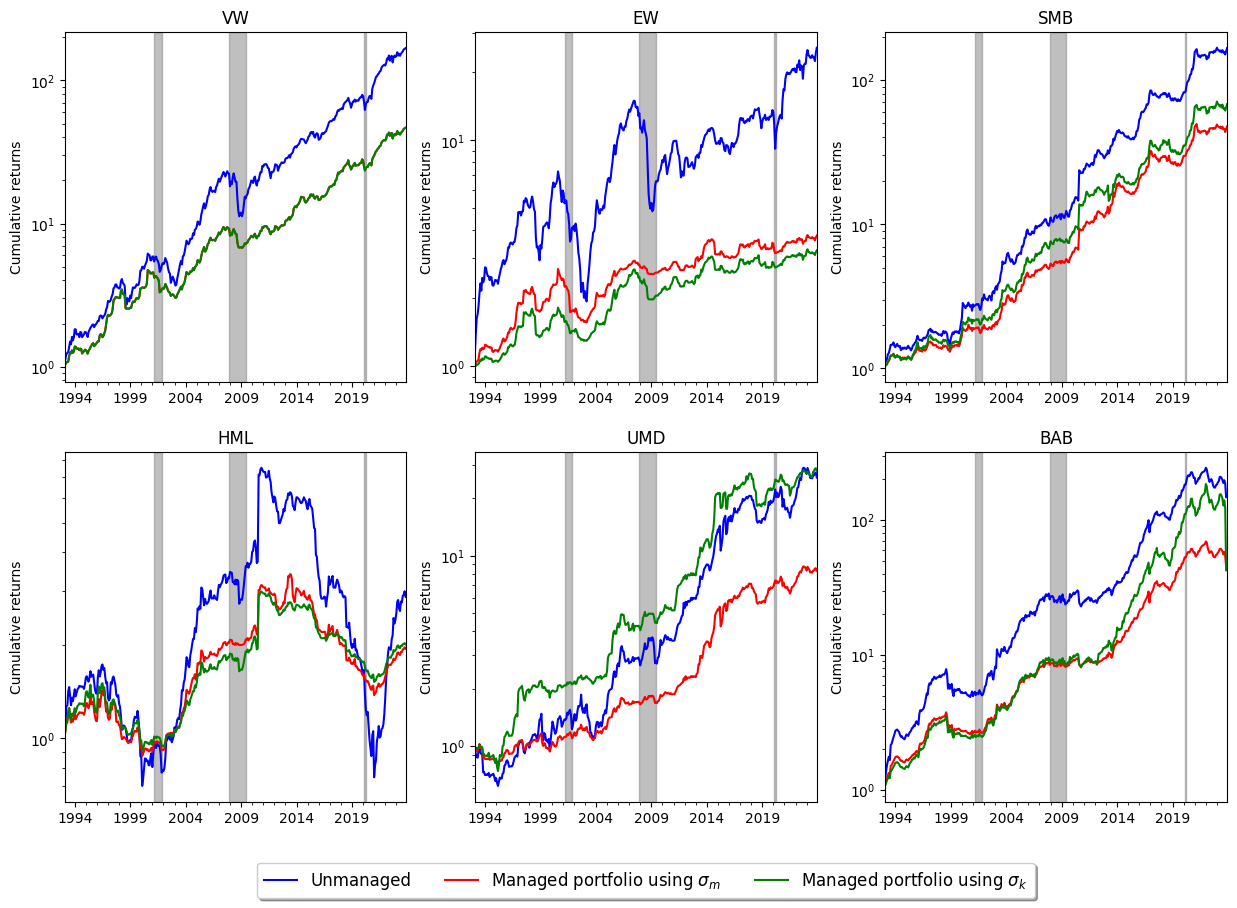

In [31]:
### Plotting cumulative returns for all the 6 factors volatility managed and not. In a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Define the recession periods
recessions = [
    ('1983-07-01', '1983-11-30'),
    ('1990-07-01', '1991-03-31'),
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

for i, factor in enumerate(factor_ret_m.columns):
    #axs[i].plot((1 + r[factor]).cumprod(), label='Simple return', color='black')
    (1 + r[factor]).cumprod().plot(ax=axs[i], title=factor, color='blue', label='Unmanaged')
    (1 + r_sigma_m_ptf[factor]).cumprod().plot(ax=axs[i], title=factor, color='red', label=r'Managed portfolio using $\sigma_m$')
    (1 + r_sigma_k_ptf[factor]).cumprod().plot(ax=axs[i], title=factor, color='green', label=r'Managed portfolio using $\sigma_k$')

    # Add grey fields for recessions
    for start, end in recessions:
        axs[i].axvspan(start, end, color='grey', alpha=0.5)

    # Remove the x-axis label
    axs[i].set_xlabel('')

    # Set the y-axis label
    axs[i].set_ylabel('Cumulative returns')

    # Add log scale
    axs[i].set_yscale('log')

    if factor == "UMD":
        # adding a legend under the plot
        axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=3, fontsize = 'large')

plt.savefig('Plots/cumulative_returns_factors.png')
plt.show()